In [188]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from train_lid_driven_cavity_azulay import custom_loss

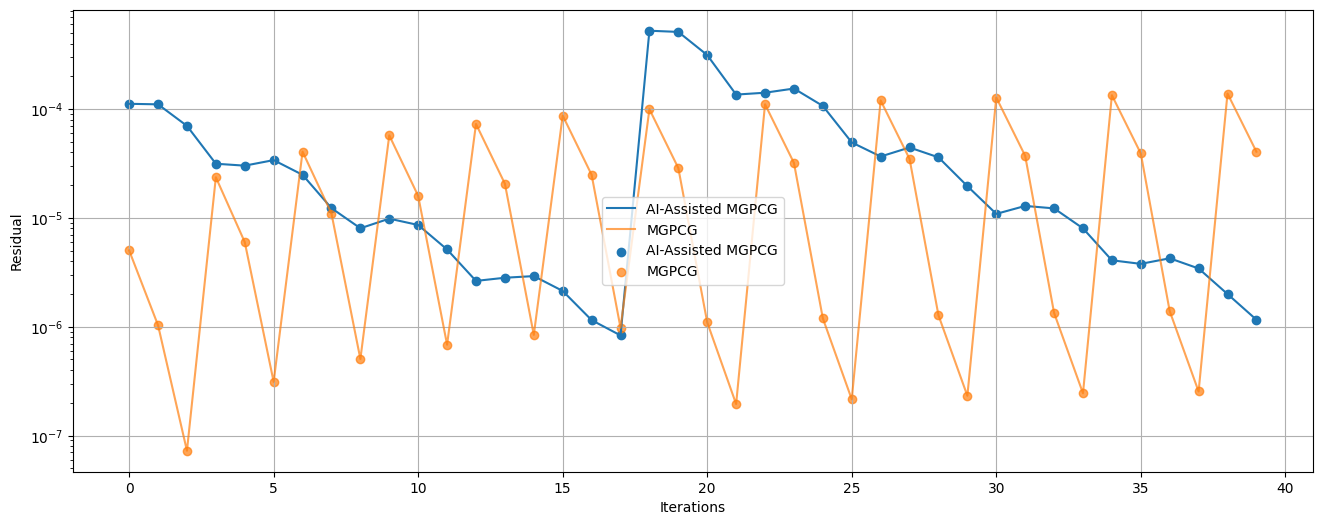

In [189]:
ml_residuals = np.loadtxt("../experiments/2d/ml/residuals_with_pressure_solver.dat")
mgpcg_residuals = np.loadtxt("../experiments/2d/mgpcg/residuals_with_pressure_solver.dat")

# last 60 iterations
ml_residuals = ml_residuals[:40]
mgpcg_residuals = mgpcg_residuals[:40]

# Plot the residuals

# Set title ()
plt.figure(figsize=(16, 6))
plt.plot(ml_residuals, label="AI-Assisted MGPCG")
plt.plot(mgpcg_residuals, label="MGPCG", alpha=0.7)
# scatter plot
plt.scatter(np.arange(len(ml_residuals)), ml_residuals, label="AI-Assisted MGPCG")
plt.scatter(np.arange(len(mgpcg_residuals)), mgpcg_residuals, label="MGPCG", alpha=0.7)

plt.yscale("log")
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.legend()
# grid lines
plt.grid(True)
plt.show()

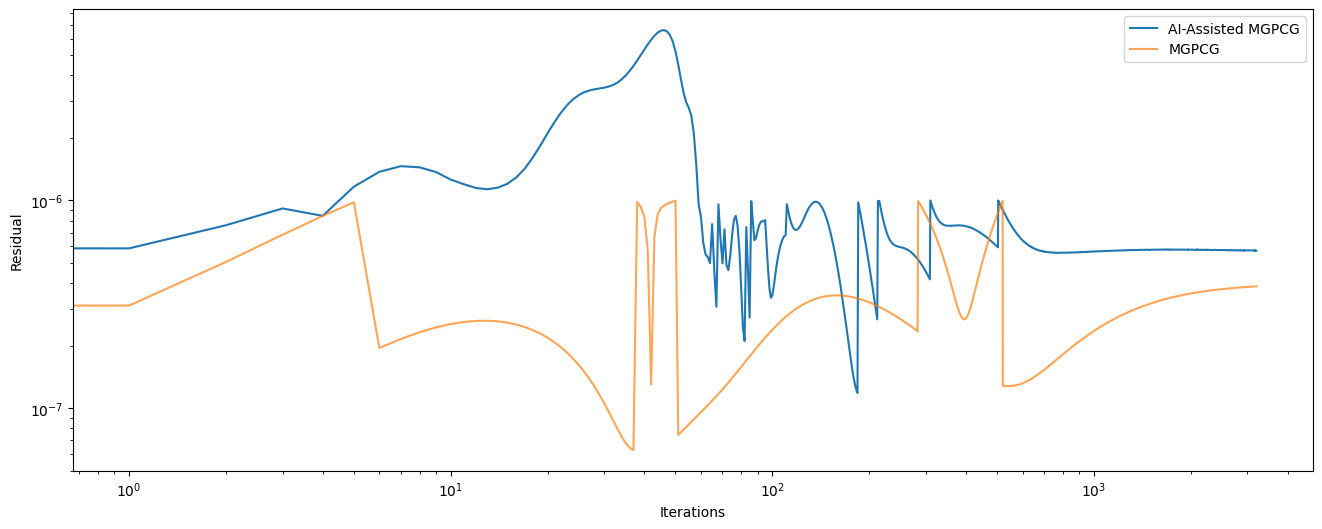

In [190]:
ml_residuals_without = np.loadtxt("../experiments/2d/ml/residuals_without_pressure_solver.dat")
mgpcg_residuals_without = np.loadtxt("../experiments/2d/mgpcg/residuals_without_pressure_solver.dat")

# Plot the residuals

# Set title, explain what plot ist
plt.figure(figsize=(16, 6))
plt.plot(ml_residuals_without, label="AI-Assisted MGPCG")
plt.plot(mgpcg_residuals_without, label="MGPCG", alpha=0.7)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("Iterations")
plt.ylabel("Residual")
plt.legend()
plt.show()

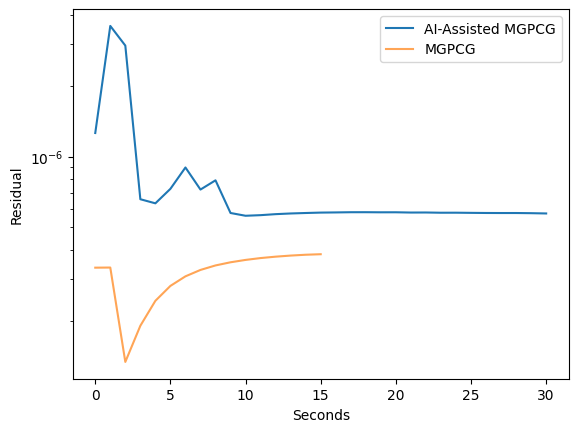

In [191]:
ml_residuals_over_time = np.loadtxt("../experiments/2d/ml/residuals_over_time.dat")
mgpcg_residuals_over_time = np.loadtxt("../experiments/2d/mgpcg/residuals_over_time.dat")

# Plot the residuals
plt.plot(ml_residuals_over_time, label="AI-Assisted MGPCG")
plt.plot(mgpcg_residuals_over_time, label="MGPCG", alpha=0.7)

plt.yscale("log")
plt.xlabel("Seconds")
plt.ylabel("Residual")
plt.legend()
plt.show()

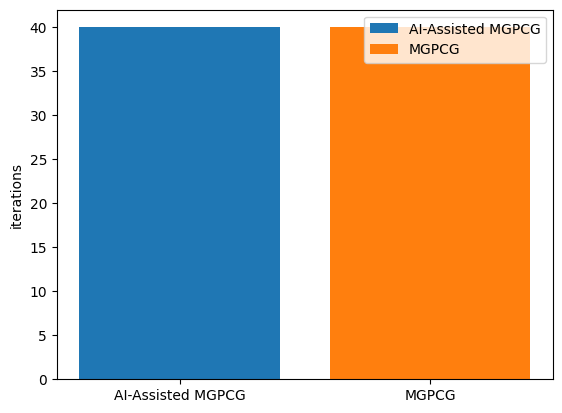

In [192]:
# plot bar charts of number of iterations
ml_iterations = len(ml_residuals)
mgpcg_iterations = len(mgpcg_residuals)
fig, ax = plt.subplots()
ax.bar("AI-Assisted MGPCG", ml_iterations, label="AI-Assisted MGPCG")
ax.bar("MGPCG", mgpcg_iterations, label="MGPCG")
plt.ylabel("iterations")
plt.legend()
plt.show()

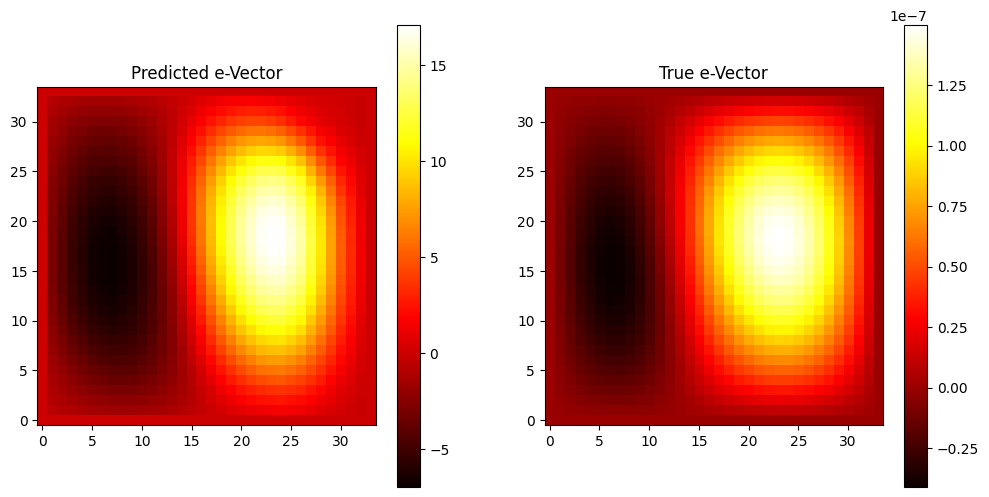

In [193]:
num_file = 2
residual_data = np.loadtxt(f"ML_data/res_{num_file}.dat")
true_error = np.loadtxt(f"ML_data/e_{num_file}.dat")
residual_data = torch.tensor(residual_data).to('cuda')

# Load the torchscript model
model = torch.jit.load("model.pt")
model.eval()

# Calculate e_data with the model
with torch.no_grad():
    e_data = model(residual_data.float().unsqueeze(0).unsqueeze(0))
    # Plot e_data as heatmap
    e_data = e_data.to('cpu').squeeze(0).squeeze(0)
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # Plot e_data from the model
    im1 = axs[0].imshow(e_data, cmap='hot', interpolation='nearest')
    axs[0].set_title('Predicted e-Vector')
    axs[0].invert_yaxis()
    fig.colorbar(im1, ax=axs[0])

    # Calculate loss
    grid_size_x, grid_size_y = e_data.shape
    pred_error = e_data.unsqueeze(0).unsqueeze(0).to('cpu')
    true_error = torch.tensor(true_error).unsqueeze(0).unsqueeze(0).to('cpu')

# Load e_data from file
e_data = np.loadtxt(f"ML_data/e_{num_file}.dat")
# Plot e_data from file as heatmap
im2 = axs[1].imshow(e_data, cmap='hot', interpolation='nearest')
axs[1].set_title('True e-Vector')
axs[1].invert_yaxis()
fig.colorbar(im2, ax=axs[1])

plt.show()

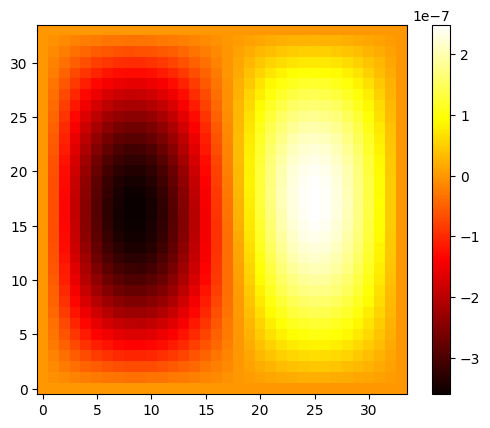

In [194]:
e_data = np.loadtxt("ML_data/e_50.dat")
# plot e_data as heatmap
plt.imshow(e_data, cmap='hot', interpolation='nearest')
# invert the y-axis
plt.gca().invert_yaxis()
plt.colorbar()
plt.show()

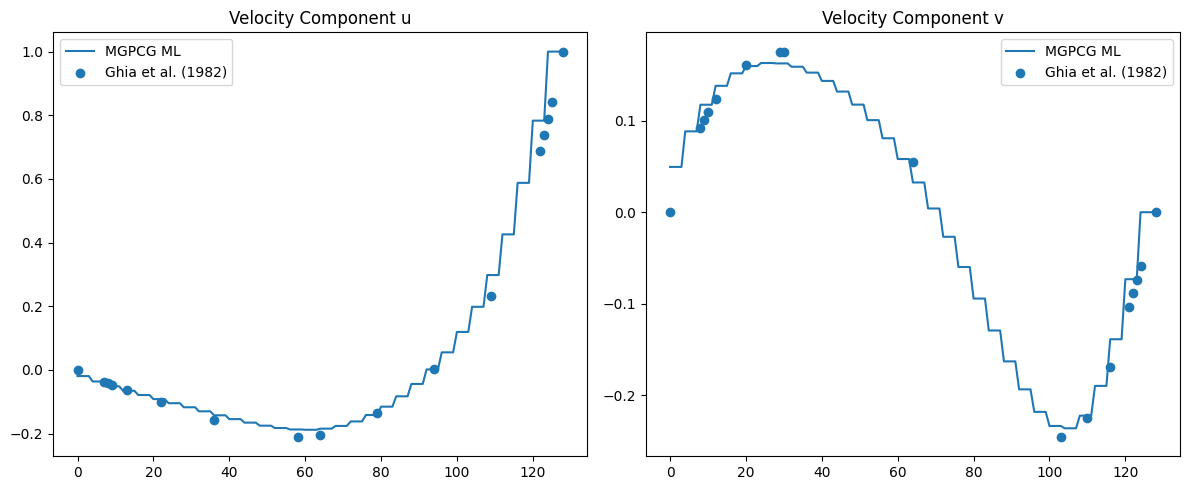

In [195]:
# Ghia et al. (1982) - Re = 100
reference_ux_RE_100 = {
    128: 1.00000,
    125: 0.84123,
    124: 0.78871,
    123: 0.73722,
    122: 0.68717,
    109: 0.23151,
    94: 0.00332,
    79: -0.13641,
    64: -0.20581,
    58: -0.21090,
    36: -0.15662,
    22: -0.10150,
    13: -0.06434,
    9: -0.04775,
    8: -0.04192,
    7: -0.03717,
    0: 0.00000
}

# Ghia et al. (1982) - Re = 100
reference_uy_RE_100 = {
    128: 0.00000,
    124: -0.05906,
    123: -0.07391,
    122: -0.08864,
    121: -0.10313,
    116: -0.16914,
    110: -0.22445,
    103: -0.24533,
    64: 0.05454,
    30: 0.17527,
    29: 0.17507,
    20: 0.16077,
    12: 0.12317,
    10: 0.10890,
    9: 0.10091,
    8: 0.09233,
    0: 0.00000
}

u = np.loadtxt("../experiments/2d/ml/u.dat")
v = np.loadtxt("../experiments/2d/ml/v.dat")

u = u[1:-1, 1:-1]
v = v[1:-1, 1:-1]

scale_factor = 4
u = np.kron(u, np.ones((scale_factor, scale_factor)))
v = np.kron(v, np.ones((scale_factor, scale_factor)))

# plot u
u = u[:, int(u.shape[1]/2)]
v = v[int(v.shape[0]/2), :]

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 2 subplots side by side

# Plot u and its reference
axes[0].plot(u, label="MGPCG ML")
axes[0].scatter(reference_ux_RE_100.keys(), reference_ux_RE_100.values(), label="Ghia et al. (1982)")
axes[0].set_title("Velocity Component u")
axes[0].legend()

# Plot v and its reference
axes[1].plot(v, label="MGPCG ML")
# plot v_mid as scatter plot
axes[1].scatter(reference_uy_RE_100.keys(), reference_uy_RE_100.values(), label="Ghia et al. (1982)")
axes[1].set_title("Velocity Component v")
axes[1].legend()

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()